In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!pip install folium
!pip install seaborn matplotlib
!pip install scikit-learn

In [2]:
from google.colab import files
files.upload()

Output hidden; open in https://colab.research.google.com to view.

In [4]:
import pandas as pd
df = pd.read_csv("/content/dataset_TSMC2014_TKY.csv")
df.head()

,userId,venueId,venueCategoryId,venueCategory,latitude,longitude,timezoneOffset,utcTimestamp
0,1541,4f0fd5a8e4b03856eeb6c8cb,4bf58dd8d48988d10c951735,Cosmetics Shop,35.705101,139.619590,540,Tue Apr 03 18:17:18 +0000 2012
1,868,4b7b884ff964a5207d662fe3,4bf58dd8d48988d1d1941735,Ramen / Noodle House,35.715581,139.800317,540,Tue Apr 03 18:22:04 +0000 2012
2,114,4c16fdda96040f477cc473a5,4d954b0ea243a5684a65b473,Convenience Store,35.714542,139.480065,540,Tue Apr 03 19:12:07 +0000 2012
3,868,4c178638c2dfc928651ea869,4bf58dd8d48988d118951735,Food & Drink Shop,35.725592,139.776633,540,Tue Apr 03 19:12:13 +0000 2012
4,1458,4f568309e4b071452e447afe,4f2a210c4b9023bd5841ed28,Housing Development,35.656083,139.734046,540,Tue Apr 03 19:18:23 +0000 2012


In [5]:
print("Missing values:\n", df.isnull().sum())
df = df.dropna(subset=['latitude','longitude'])
df = df.drop_duplicates()
df.shape

Missing values:
 userId             0
venueId            0
venueCategoryId    0
venueCategory      0
latitude           0
longitude          0
timezoneOffset     0
utcTimestamp       0
dtype: int64


(573126, 8)

In [6]:
df = df.sample(n=20000, random_state=42)
df.shape

(20000, 8)

In [8]:
import folium
from folium.plugins import HeatMap

m = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=10)

HeatMap(
    data=df[['latitude','longitude']].values.tolist(),
    radius=6
).add_to(m)

m

In [10]:
from sklearn.preprocessing import StandardScaler

coords = df[['latitude','longitude']]
scaler = StandardScaler()
scaled = scaler.fit_transform(coords)

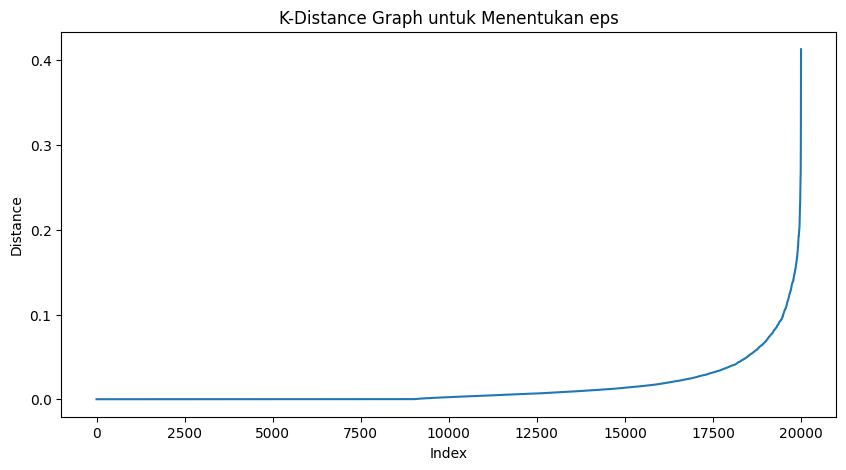

In [12]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(scaled)
distances, indices = neighbors_fit.kneighbors(scaled)

distances = np.sort(distances[:,4])

plt.figure(figsize=(10,5))
plt.plot(distances)
plt.title("K-Distance Graph untuk Menentukan eps")
plt.xlabel("Index")
plt.ylabel("Distance")
plt.show()

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.22, min_samples=5).fit(scaled)

df['cluster'] = dbscan.labels_
df['cluster'].value_counts()

,count
cluster,
0,19934
1,29
2,12
-1,11
3,5
4,5
5,4


In [16]:
from sklearn.metrics import silhouette_score

mask = df['cluster'] != -1

if df[mask]['cluster'].nunique() > 1:
    score = silhouette_score(scaled[mask], df['cluster'][mask])
    print("Silhouette Score:", score)
else:
    print("Silhouette Score tidak dapat dihitung (hanya 1 cluster / semua noise).")

Silhouette Score: 0.037983151851609234


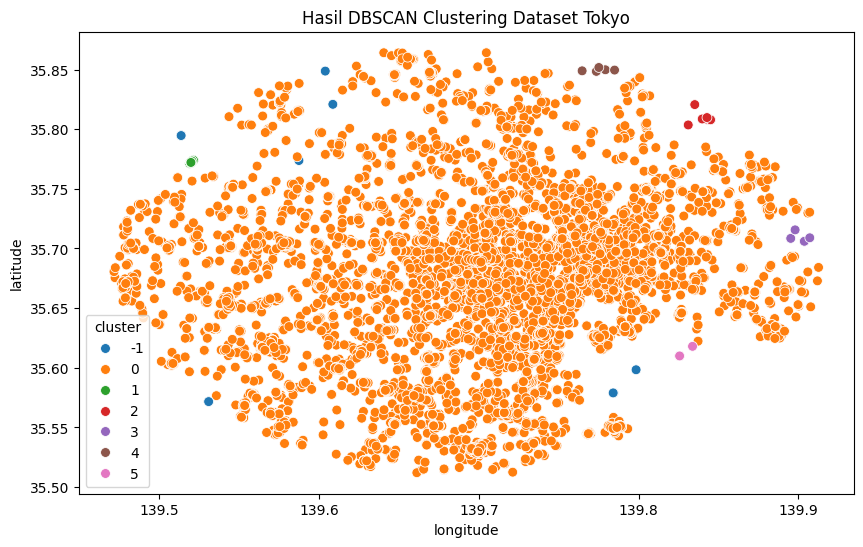

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.scatterplot(
    x=df['longitude'],
    y=df['latitude'],
    hue=df['cluster'],
    palette='tab10',
    s=50
)
plt.title("Hasil DBSCAN Clustering Dataset Tokyo")
plt.show()

In [19]:
cluster_map = folium.Map(location=[df.latitude.mean(), df.longitude.mean()], zoom_start=10)

colors = ['red','blue','green','purple','orange','black','yellow','pink']

for _, row in df.iterrows():
    folium.CircleMarker(
        location=[row['latitude'], row['longitude']],
        radius=5,
        color='gray' if row['cluster']==-1 else colors[row['cluster'] % len(colors)],
        fill=True,
        popup=f"Cluster: {row['cluster']}"
    ).add_to(cluster_map)

cluster_map

Output hidden; open in https://colab.research.google.com to view.

In [20]:
summary = df.groupby('cluster').size().reset_index(name="Jumlah Data")
summary

,cluster,Jumlah Data
0,-1,11
1,0,19934
2,1,29
3,2,12
4,3,5
5,4,5
6,5,4
